<style>
a {
    color: #a63bff !important;
    font-size: 25px !important;
}
</style>

* <a href="#1">1. Start</a>
* <a href="#2">2. Исследование данных</a>
  * <a href="#2.1">2.1 Объединение</a>
  * <a href="#2.2">2.2 Анализ дат </a>
  * <a href="#2.3">2.3 Анализ отелей </a>
  * <a href="#2.4">2.4 Информация о рецензенте</a>
  * <a href="#2.5">2.5 Обработка отзывов</a>
* <a href="#3">3. Drop</a>
* <a href="#4">4. Model</a>
* <a href="#5">5. Conclusion</a>
* <a href="#6">6. Запас </a>  

<a id = '1'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>1. Start</strong>
</p>

In [1]:
%%capture

##############################################

# https://www.kaggle.com/code/fobosal/project-3-booking

# установка дополнительных библиотек:
# !pip install Afinn
# !pip install nltk[twitter]
# !pip install wordcloud
# !pip install spacy 

#python -m spacy download en_core_web_lg
#python -m spacy download en_core_web_sm


import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px
%matplotlib inline

from wordcloud import WordCloud

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

import warnings
pd.options.mode.chained_assignment = None # SettingWithCopyWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning ignore

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
# Для воспроизводимости зафиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [3]:
# данные из соревнования
#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

#DATA_DIR = 'data/sf-booking'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
#df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') 
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

DATA_DIR = 'P:/_Data Scientist DSPR-107/EDA-7. PROJECT-3. Feature Engineering. Соревнование на Kaggle/data/sf-booking'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')


<a id = '2'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>2. Исследование данных</strong>
</p>

In [4]:
new_df = df_train[[df_train.columns[4], df_train.columns[0]]]

In [5]:
df1 = df_train[['hotel_name', 'hotel_address']]

In [6]:
# Создание нового DataFrame с уникальными значениями
unique_df = df1.drop_duplicates()

# Группировка данных и сбор адресов в список для каждого отеля
grouped_addresses = unique_df.groupby('hotel_name')['hotel_address'].apply(list)

# Поиск отеля с двумя разными адресами
for hotel, addresses in grouped_addresses.iteritems():
    if len(set(addresses)) > 1:
        print("Отель:\n", hotel)
        print("Адреса:\n", addresses)
        print("-------------------------------")

Отель:
 Hotel Regina
Адреса:
 ['Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']
-------------------------------


In [8]:
grouped1_addresses = unique_df.groupby('hotel_address')['hotel_name'].apply(list)

# Поиск отеля с двумя разными адресами
for address, hotel in grouped1_addresses.iteritems():
    if len(set(hotel)) > 1:
        print("hotel:\n", hotel)
        print("address:\n", address)
        print("-------------------------------")

hotel:
 ['The Grand at Trafalgar Square', 'Club Quarters Hotel Trafalgar Square']
address:
 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
-------------------------------


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
df_train.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1472
lng                                             1472
dtype: int64

In [11]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [13]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [14]:
sample_submission.head(5)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [15]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [16]:
# Подсчитываем количество дубликатов
количество_дубликатов = df_train.duplicated().sum()

print("Количество дубликатов:", количество_дубликатов)

Количество дубликатов: 307


In [17]:
# Фильтруем и выводим все дубликаты
дубликаты = df_train[df_train.duplicated(keep=False)]
display(дубликаты)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
1674,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/29/2016,7.9,H tel Concorde Montparnasse,United Kingdom,No Negative,0,2515,I drove to France to settle my daughter into ...,40,14,9.6,"[' Solo traveler ', ' Classic Twin Room ', ' S...",339 day,48.838108,2.318669
2336,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,1/14/2017,7.9,H tel Concorde Montparnasse,Saudi Arabia,nothing,2,2515,no,2,21,5.0,"[' Business trip ', ' Group ', ' Classic Twin ...",201 day,48.838108,2.318669
2778,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,3/12/2016,8.9,Hotel Le Sainte Beuve,Sweden,No Negative,0,143,Great location Great staff Great hotel I are ...,12,4,10.0,"[' Leisure trip ', ' Couple ', ' Superior Room...",509 day,48.843900,2.329486
3138,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/13/2017,7.9,H tel Concorde Montparnasse,Germany,the wifi was very bad room service wasn t good,11,2515,No Positive,0,1,4.6,"[' Leisure trip ', ' Solo traveler ', ' Classi...",82 days,48.838108,2.318669
4345,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/30/2016,7.9,H tel Concorde Montparnasse,Belgium,Room is very very small not even room to walk...,44,2515,Flat screen TV,4,4,2.9,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",338 day,48.838108,2.318669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383104,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,11/3/2015,9.0,H tel Baume,United States of America,Rooms are very small,6,253,Location is excellent and staff is very frien...,10,1,8.3,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",639 day,48.850152,2.339278
383183,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,7/28/2016,7.9,H tel Concorde Montparnasse,France,A bit noisy old fashion At almost 20 the brea...,18,2515,Convenient if one arrives departs from the Mo...,10,48,6.7,"[' Business trip ', ' Solo traveler ', ' Class...",371 day,48.838108,2.318669
383798,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/15/2017,7.9,H tel Concorde Montparnasse,United Kingdom,twice spoken to staff to replace the coffee w...,24,2515,Tea making facilities not in the room only co...,11,2,7.9,"[' Leisure trip ', ' Couple ', ' Superior Doub...",80 days,48.838108,2.318669
384118,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,10/12/2015,7.9,H tel Concorde Montparnasse,Australia,No great restaurants within a short walk but ...,12,2515,The Hotel was wonderfully p laced for us to a...,44,24,10.0,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",661 day,48.838108,2.318669


In [18]:
дубликаты.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 1674 to 385441
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hotel_address                               614 non-null    object 
 1   additional_number_of_scoring                614 non-null    int64  
 2   review_date                                 614 non-null    object 
 3   average_score                               614 non-null    float64
 4   hotel_name                                  614 non-null    object 
 5   reviewer_nationality                        614 non-null    object 
 6   negative_review                             614 non-null    object 
 7   review_total_negative_word_counts           614 non-null    int64  
 8   total_number_of_reviews                     614 non-null    int64  
 9   positive_review                             614 non-null    object 
 10  review_t

In [19]:
# Подсчитываем количество дубликатов
количество_дубликатов = df_test.duplicated().sum()

print("Количество дубликатов:", количество_дубликатов)

Количество дубликатов: 29


# Объединение

In [20]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# объединяем данные в один dataset
df = pd.concat([df_train, df_test], ignore_index=True)
#df['sample'] = df['sample'].astype('category')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [22]:
data = df.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [23]:
#data1 = df.copy()
#data1.info()

In [24]:
#data = data1.drop_duplicates()

In [25]:
data.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'sample'],
      dtype='object')

In [26]:
#в каких столбцах числовые значения:
digit_columns = [s for s in data.columns if (data[s].dtypes == 'int64') | (data[s].dtypes == 'float64')]
digit_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng',
 'sample']

In [27]:
#в каких столбцах строковые значения:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Date

In [29]:
# Создадим новые признаки из даты: год, месяц
data['review_date'] = pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year

In [30]:
# Сгрупируем по отелям и посмотрим у каких отелей отсутствуют геоданные
hotels_with_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
hotels_with_coor.head(2)

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55


# hotel_country

In [31]:
data['hotel_address'].unique()

array(['Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom',
       '130 134 Southampton Row Camden London WC1B 5AF United Kingdom',
       '151 bis Rue de Rennes 6th arr 75006 Paris France', ...,
       'Prinsengracht 717 Amsterdam City Center 1017 JW Amsterdam Netherlands',
       '43 Rue De l Abb Gr goire 6th arr 75006 Paris France',
       'Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria'],
      dtype=object)

Комментарии / выводы:

Из анализа созданных новых признаков мы видим, что отели распологаются в 6 странах и в 6 крупных городах - туристических центрах. Количественные данные совпадают. Для построения модели ML предлагается произвести кодировку по методу однократного кодирования OneHot.

In [32]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = data[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = data['hotel_name'].isin(name_rep)
addresses_rep = data[mask][['hotel_name', 'hotel_address']].value_counts()

print('Дублирование названия отеля:')
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город:
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print('\nПроверим полученные изменения:')
mask = data['hotel_name'].str.contains(name_rep[0])
display(data[mask]['hotel_name'].value_counts())

Дублирование названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64


Проверим полученные изменения:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

In [33]:
#выбираем страну из адреса отеля
data['hotel_country'] = data['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

In [34]:
# Для распечатки в цвете
from termcolor import colored

data['hotel_city'] = data['hotel_address'].apply\
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

print(colored('\n Какие города получились в датасете:', 'green'))
data['hotel_city'].value_counts()



 Какие города получились в датасете:


London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [35]:
#закодируем название стран
import category_encoders as ce
encoder = ce.OneHotEncoder()
data['make_hotel_name'] = data['hotel_country'].astype('category')
data_bin = encoder.fit_transform(data['hotel_country'])
data_bin.rename(columns={'hotel_country' : 'hotel_country_c'}, inplace=True)
data = pd.concat([data, data_bin], axis=1)

In [36]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1494
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
month                                         

<AxesSubplot: >

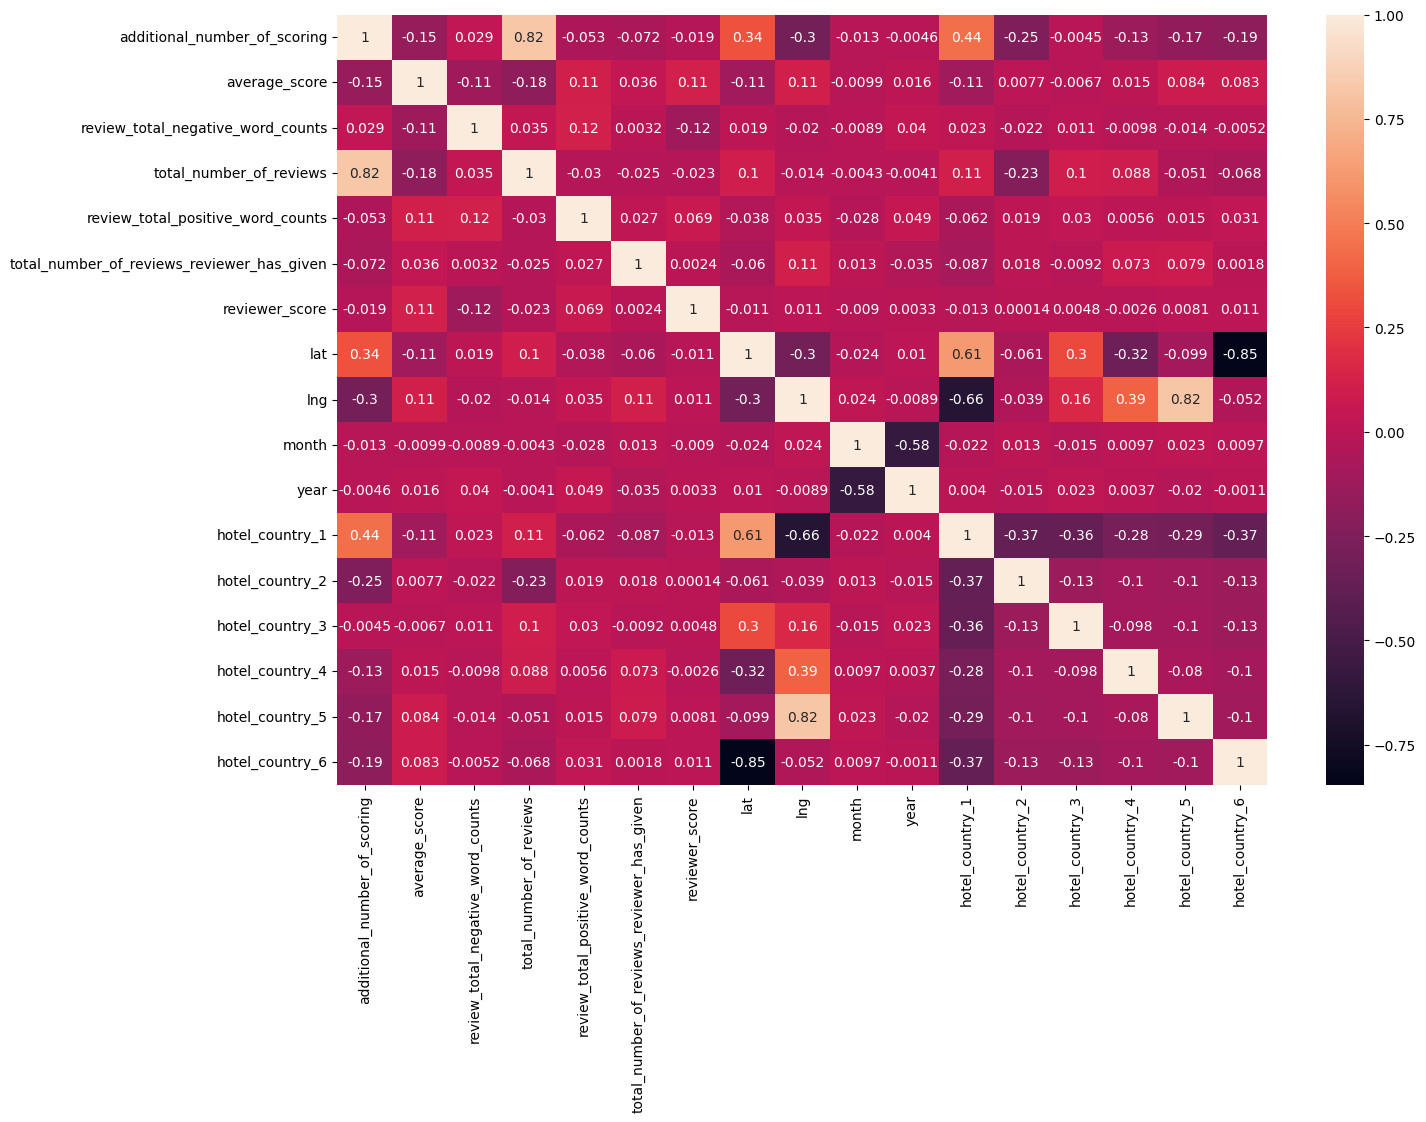

In [37]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [38]:
data.sample(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,year,hotel_country,hotel_city,make_hotel_name,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6
425834,Cardington Street Euston Camden London NW1 2LP...,744,2016-08-18,8.3,Thistle Euston,United Kingdom,Bar prices,3,2474,They done a nice presentation for our 30th do...,...,2016,United Kingdom,London,United Kingdom,1,0,0,0,0,0
267058,61 Lincoln s Inn Fields Camden London WC2A 3JW...,681,2015-10-15,8.9,Club Quarters Hotel Lincoln s Inn Fields,United Kingdom,No Negative,0,2692,What a fabulous find in the centre of the Lon...,...,2015,United Kingdom,London,United Kingdom,1,0,0,0,0,0
210057,19 Rue Cujas 5th arr 75005 Paris France,80,2016-10-06,8.8,Grand Hotel Saint Michel,United Kingdom,No Negative,0,625,Very helpful and friendly staff Room small bu...,...,2016,France,Paris,France,0,1,0,0,0,0


# lat lng

In [39]:
#поиск пропусков в данных

null_data = data.isnull().sum()

print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
lat    3268
lng    3268
dtype: int64


In [40]:
# Нехитрым способом проверим, что пропуски по геоданным у одних и тех же записей.
# Как видим, мы выбрали данные где одновременно присутствует пропуски по обоим признакам,
# отняли от общего кол-ва записей и кол-во оставшихся записей точно равно данным из data.info()
data[(data.lng.isna()) & (data.lat.isna())].shape[0] - data.shape[0]

-512470

In [41]:
# формируем словарь с данными по широте
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '48.21974808057666', 
                'Holiday Inn Paris Montmartre': '48.889064368690235',
                'Fleming s Selection Hotel Wien City': '48.20949471863499',
                'Hotel Atlanta': '48.2209723965124',
                'Maison Albar Hotel Paris Op ra Diamond': '48.87543722920124',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '48.24608017805536',
                'Hotel City Central': '48.214201786014854',
                'NH Collection Barcelona Podium': '41.39176529029773',
                'City Hotel Deutschmeister': '48.22103057609981',
                'Hotel Daniel Vienna': '48.18897212994251',
                'Roomz Vienna': '48.22382961585223',
                'Hotel Pension Baron am Schottentor': '48.21692824899107',
                'Mercure Paris Gare Montparnasse': '48.84010021974514',
                'Hotel Park Villa': '48.23759024291264',
                'Hotel Advance': '41.38327316014033',
                'Renaissance Barcelona Hotel': '41.394162363243964',
                'Cordial Theaterhotel Wien': '48.20969901650749'}

In [42]:
# формируем словарь с данными по долготе
dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '16.285624283904383', 
                'Holiday Inn Paris Montmartre': '2.333206641604505',
                'Fleming s Selection Hotel Wien City': '16.35350997041095',
                'Hotel Atlanta': '16.356650516337886',
                'Maison Albar Hotel Paris Op ra Diamond': '2.3234027262612256',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '16.34202545691955',
                'Hotel City Central': '16.379923233140797',
                'NH Collection Barcelona Podium': '2.1783660658934747',
                'City Hotel Deutschmeister': '16.366622226233126',
                'Hotel Daniel Vienna': '16.3838329415743',
                'Roomz Vienna': '16.393969343883455',
                'Hotel Pension Baron am Schottentor': '16.360055901096636',
                'Mercure Paris Gare Montparnasse': '2.3231778953046462',
                'Hotel Park Villa': '16.34703938556462',
                'Hotel Advance': '2.162964217594162',
                'Renaissance Barcelona Hotel': '2.1748749075722924',
                'Cordial Theaterhotel Wien': '16.351495483903957'}

In [43]:
# формируем код и производим заполнение данных в dataframe
data['lat'] = data.apply(lambda x: dict_lat.get(x['hotel_name']) if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64') # вводим данные по широте и устанавливаем тип float64
data['lng'] = data.apply(lambda x: dict_lng.get(x['hotel_name']) if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64') # вводим данные по долготе и устанавливаем тип float64

In [44]:
# формируем и выводим повторно информацию о наличие пропусков после обработки
display(data.isnull().sum())

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
month                                         0
year                                          0
hotel_country                           

# расстояние до центра

Можно рассчитать расстояние от отеля до центра города, возможно это влияет на оценку отеля.

In [45]:
%%time

import geopy.distance

# для формирования нового признака используются координаты центра каждого города 

centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

#функция вычисления до центра города по координатам
def get_dist_to_center(country, lng, lat):
   
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

hotels_coord = data[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_coord['hotel_distance_to_center'] = data.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_coord.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)

data = data.merge(hotels_coord, how='left', on='hotel_name', sort=False)

CPU times: total: 1min 33s
Wall time: 1min 33s


In [46]:
#посмотрим новый признак
data[['hotel_country', 'hotel_distance_to_center', 'reviewer_score']].sort_values(by='hotel_country').iloc[:10]

,hotel_country,hotel_distance_to_center,reviewer_score
387135,Austria,4.060249,0.0
403129,Austria,1.229248,0.0
221350,Austria,5.209262,7.1
113036,Austria,0.572859,9.2
40862,Austria,0.683433,7.9
113023,Austria,0.135233,8.3
40868,Austria,1.088678,10.0
113013,Austria,1.503339,9.2
221370,Austria,8.062943,9.6
494998,Austria,0.135233,0.0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [48]:
# Сгрупируем по отелям и посмотрим у каких отелей отсутствуют геоданные
hotels_with_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
hotels_with_coor.head(2)

,hotel_address,hotel_name,additional_number_of_scoring


# nationality

In [49]:
data['reviewer_nationality'].describe()

count               515738
unique                 227
top        United Kingdom 
freq                245246
Name: reviewer_nationality, dtype: object

In [50]:
#сгруппириуем данные для оценки параметра национальность
data1 = data[data['sample'] == 1]
data1 = data1.groupby('reviewer_nationality')['reviewer_score'].agg('mean').reset_index().sort_values(by='reviewer_score').iloc[:20]
data1.head()

,reviewer_nationality,reviewer_score
5,American Samoa,4.60
47,Cook Islands,5.00
137,Montserrat,5.40
149,Northern Mariana Islands,5.80
127,Mali,6.44


In [51]:
from colorama import Fore, Back, Style
# Null записей нету, но проверим на всякий случай, нет ли пустых записей
cnt_no_nationality = data[data.reviewer_nationality.str.strip() == ''].shape[0]
print(Fore.LIGHTCYAN_EX + "\nКоличество записей без указанной национальности reviewer-а:",cnt_no_nationality)


Количество записей без указанной национальности reviewer-а: 523


Количество записей без указанной национальности reviewer-а: 523

In [52]:
# заполним модой
mode_country_reviewer = data.reviewer_nationality.mode().item()
data.loc[data[data.reviewer_nationality.str.strip() == ''].index,'reviewer_nationality'] = mode_country_reviewer

In [53]:
# Наш топ 122. Почему 122, просто решил что примерно 50 отзывов, это минимальное, что 
# может нести в себе более менее усредненную информацию
countries_top = data['reviewer_nationality'].value_counts().nlargest(122)
countries_top.index = countries_top.index.map(str.strip)
countries_top

United Kingdom              245769
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
                             ...  
Zimbabwe                        51
Sudan                           51
Maldives                        49
Uganda                          47
Botswana                        42
Name: reviewer_nationality, Length: 122, dtype: int64

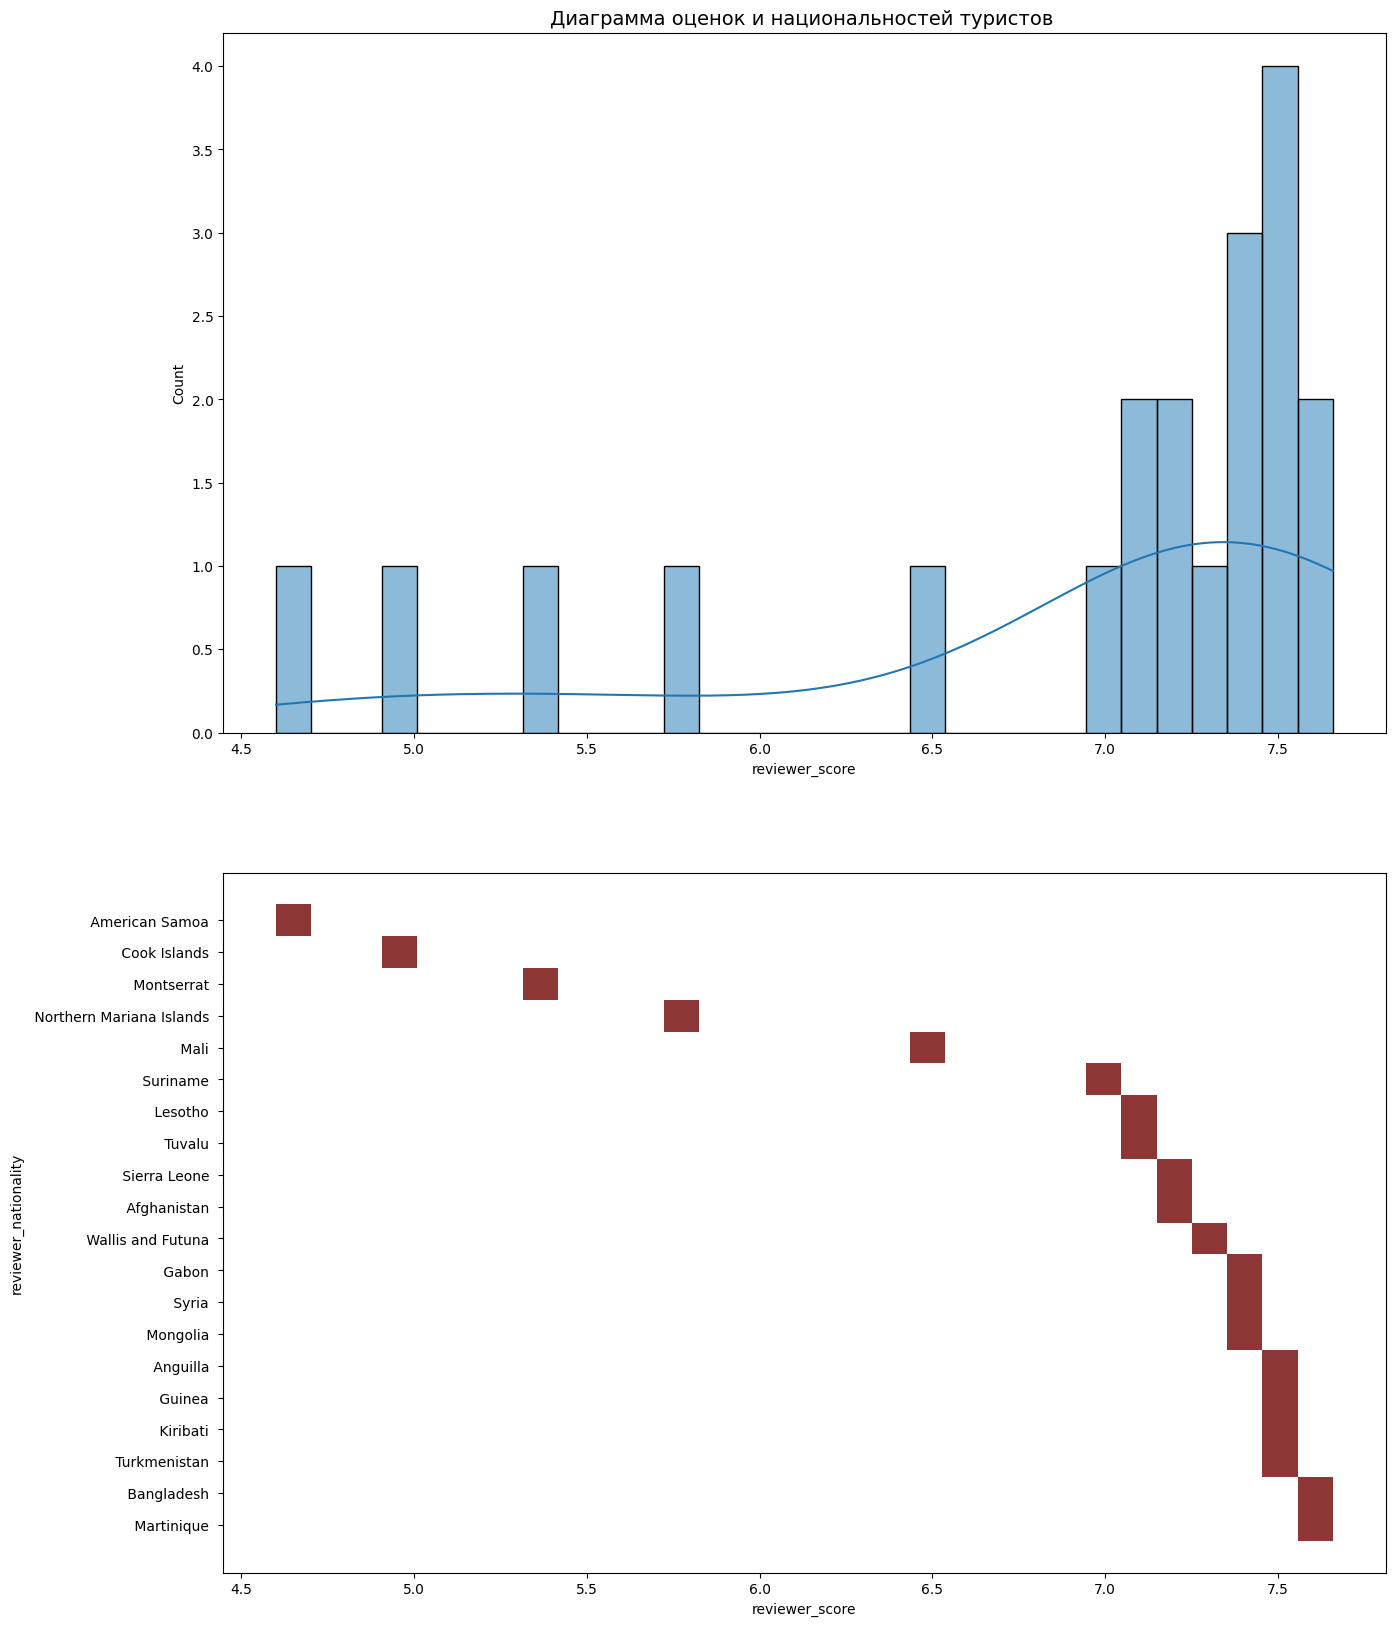

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
sns.histplot(
    data = data1,
    x = 'reviewer_score',
    bins = 30,
    kde = True,
    ax = axes[0]
);
axes[0].set_title('Диаграмма оценок и национальностей туристов ', fontsize = 14)
sns.histplot(
    data = data1,
    x = 'reviewer_score',
    y = 'reviewer_nationality',
    bins = 30,
    color = 'red',
    ax = axes[1]
);

In [55]:
#закодируем название национальностей
import category_encoders as ce
ord_encoder = ce.OrdinalEncoder()
data['make_nationality'] = data['reviewer_nationality'].astype('category')
data_bin = ord_encoder.fit_transform(data['reviewer_nationality'])
data_bin.rename(columns={'reviewer_nationality' : 'nationality'}, inplace=True)
data = pd.concat([data, data_bin], axis=1)

In [56]:
data[['reviewer_nationality', 'nationality']].value_counts()

reviewer_nationality        nationality
 United Kingdom             1              245769
 United States of America   12              35437
 Australia                  36              21686
 Ireland                    21              14827
 United Arab Emirates       8               10235
                                            ...  
 Northern Mariana Islands   220                 1
 Vatican City               225                 1
 Guinea                     169                 1
 Anguilla                   164                 1
 Svalbard Jan Mayen         218                 1
Length: 226, dtype: int64

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

# анализ отзывов

In [58]:
%%time

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делов подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])


CPU times: total: 3min 20s
Wall time: 3min 20s


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

# Drop

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [61]:
data.drop(['lat','lng'], axis = 1, inplace=True)

In [62]:
#data.drop('year', axis = 1, inplace=True)

In [63]:
#del data['make_hotel_name']

In [64]:
#del data['make_nationality']

In [65]:
# посмотрим признаки, которые типов категория, дата, и строки
def getNonNumberTypeFeatures(df):
    """Функция возвращает в списке все признаки из датасета, что подходят под описанные правила

    Args:
        df (pandas.Dataframe()): Датасет

    Returns:
        list: Список признаков
    """
    object_columns = [s for s in data.columns
                    if ((data[s].dtypes == 'object') | \
                        (data[s].dtype.name == 'category') | \
                        (data[s].dtypes == 'datetime64[ns]') |
                        (data[s].dtype.name == 'period[M]'))]
    return object_columns

types_list = getNonNumberTypeFeatures(data)
#print(Fore.LIGHTCYAN_EX + "\nКоличество признаков, которые надо удалить,\
# либо привести к машиноподходящему типу:",Fore.LIGHTGREEN_EX, types_list.__len__())
display(types_list)

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_country',
 'hotel_city',
 'make_hotel_name',
 'make_nationality',
 'neg_scores',
 'pos_scores']

In [66]:
data.drop(types_list, axis = 1, inplace=True)

In [67]:
data.sample(5)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,sample,month,year,...,hotel_distance_to_center,nationality,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
334963,532,8.6,16,4276,24,3,9.2,1,10,2016,...,0.934842,53,0.201,0.671,0.128,-0.2960,0.0,0.647,0.353,0.8849
100028,406,8.2,2,2011,19,2,10.0,1,4,2017,...,1.081708,1,0.000,1.000,0.000,0.0000,0.0,0.500,0.500,0.9186
23127,60,9.5,21,632,14,39,8.3,1,5,2017,...,0.553009,1,0.102,0.795,0.103,0.0041,0.0,0.668,0.332,0.6096
162550,589,7.0,0,4231,12,2,8.8,1,9,2015,...,0.927063,1,0.000,0.000,1.000,0.5574,0.0,0.570,0.430,0.7778
218965,634,7.9,15,4065,0,10,3.3,1,12,2015,...,5.199317,43,0.000,0.825,0.175,0.3724,1.0,0.000,0.000,-0.5719


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   month                                       515738 non-null  int64  
 9   year                                        515738 non-null  int64  
 

# Model

In [69]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [70]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [71]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

In [72]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [73]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [74]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


CPU times: total: 13min 25s
Wall time: 1min 57s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [75]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.55


<AxesSubplot: >

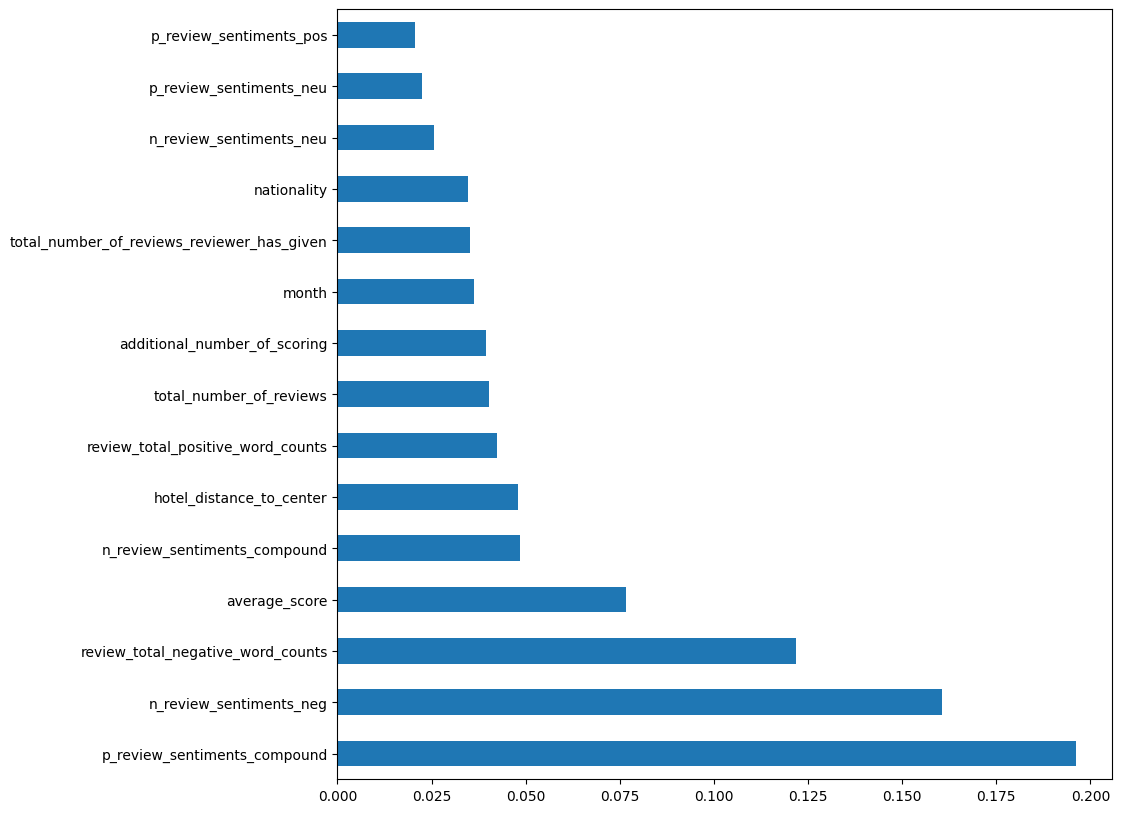

In [76]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [77]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,month,year,hotel_country_1,...,hotel_distance_to_center,nationality,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
445984,88,9.4,0,334,7,31,0.0,3,2017,1,...,2.975052,5,0.000,0.000,1.000,0.5574,0.0,0.380,0.620,0.5994
456319,107,9.0,0,917,5,3,0.0,1,2016,0,...,0.733860,40,0.000,0.000,1.000,0.5574,0.0,0.225,0.775,0.7845
465732,995,8.1,103,3826,16,1,0.0,1,2017,1,...,10.216219,1,0.022,0.894,0.084,0.7534,0.0,0.610,0.390,0.8258
386993,641,8.7,17,2130,23,3,0.0,8,2016,1,...,13.637797,1,0.250,0.612,0.138,-0.2960,0.0,0.766,0.234,0.7003
447497,484,8.7,95,1705,5,1,0.0,1,2017,1,...,4.782191,21,0.040,0.932,0.028,-0.0387,0.0,0.220,0.780,0.7947
425885,207,8.7,28,3010,6,11,0.0,6,2016,0,...,4.387010,61,0.000,0.902,0.098,0.3818,0.0,0.476,0.524,0.5106
424317,791,7.3,15,3609,21,1,0.0,12,2016,1,...,5.864381,1,0.000,0.750,0.250,0.6115,0.0,0.484,0.516,0.9319
468600,1485,7.5,36,6977,9,12,0.0,1,2016,1,...,5.101826,1,0.061,0.890,0.049,-0.1027,0.0,0.433,0.567,0.7620
450404,2288,8.1,47,9568,2,8,0.0,5,2017,1,...,0.610003,1,0.000,0.959,0.041,0.2023,0.0,1.000,0.000,0.0000
389210,258,7.4,26,3590,18,5,0.0,6,2017,0,...,2.620226,4,0.128,0.783,0.089,-0.0258,0.0,0.865,0.135,0.3612


In [78]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [79]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [80]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [81]:
predict_submission

array([8.74 , 7.684, 8.623, ..., 8.447, 9.595, 7.395])

In [82]:
list(sample_submission)

['reviewer_score', 'id']

In [83]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.740,488440
1,7.684,274649
2,8.623,374688
3,9.717,404352
4,9.557,451596
5,9.058,302161
6,7.162,317079
7,7.449,13963
8,8.105,159785
9,7.467,195089
